# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_from_array, significance_from_array
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator

# Parameters

In [2]:
dataset_path = 'data/dataset.parquet'
target_column = 'target'

# EDA

## Upload data

In [3]:
df = pd.read_parquet(dataset_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439
0,1,0,0,0,1,0,3,2,91,0,...,0,0,0,84,0,0,0,0,20,NaN
1,1,0,0,0,1,0,3,2,61,0,...,0,0,0,0,0,0,0,0,10,NaN
2,1,0,0,0,0,0,2,3,21,1,...,0,0,0,0,0,20,0,0,0,NaN
3,4,0,0,0,0,0,6,3,92,0,...,11,0,8,41,0,0,10,14,4,NaN
4,1,0,0,0,0,0,2,2,11,0,...,0,10,0,0,0,0,0,0,0,NaN


## Data Profiling

In [4]:
nan_columns = df.columns[df.isna().any()].tolist() 
nan_ratio = df.isna().mean() 

print(f'Dataframe shape: {df.shape}')
print("Columns with NaN:", nan_columns)
print("Share of NaN in these columns:")
print(nan_ratio[nan_columns])

Dataframe shape: (492300, 436)
Columns with NaN: ['425', '439']
Share of NaN in these columns:
425    0.050865
439    0.949135
dtype: float64


In [5]:
# See on '439'
df[~df['439'].isna()][target_column].value_counts(),\
df[df['439'].isna()][target_column].value_counts()

(0.0    25041
 Name: target, dtype: int64,
 0.0    462945
 1.0      4314
 Name: target, dtype: int64)

In [6]:
# We see real values are always connected with 0 label - we can keep this column
# but in future we must test to drop it

In [7]:
# See on '425'
df[~df['425'].isna()][target_column].value_counts(),\
df[df['425'].isna()][target_column].value_counts()

(0.0    462945
 1.0      4314
 Name: target, dtype: int64,
 0.0    25041
 Name: target, dtype: int64)

In [8]:
# '425' NaN is connecteed with '439'.
df[~(df['425']!=df['439'])]

,0,1,2,3,4,5,6,7,8,9,...,430,431,432,433,434,435,436,437,438,439


In [9]:
# 425 is the reverse of 439 - remove it
df = df.drop(columns=['439'])

In [10]:
# Find constant columns

X = df.drop(columns=[target_column])

constant_cols = []

for col in X.columns:
    try:
        unique_values = X[col].nunique()
        if unique_values == 1:
            constant_cols.append(col)
    except:
        print(f'Check column format for: {col}')
print(constant_cols)

['1', '58', '68', '77', '86', '115', '116', '166', '167', '171', '198', '220', '235', '238', '250', '262', '265', '267', '274', '282']


In [11]:
# drop them all, because they do not affect

df = df.drop(columns=constant_cols)

In [12]:
# see column format for dates and ids
df[df.select_dtypes(include=['object', 'string', 'datetime']).columns].head()

,17,241
0,2025-02-02 21:10:03.484,08ebba6c-37ca-4cf5-a0ba-05917eeb5375
1,2025-03-19 22:50:25.263,930942ac-a059-4c41-8d28-6affdd49ffe4
2,2025-02-17 03:45:02.598,3145eeec-76fb-489d-a100-514147f98e1c
3,2024-11-25 05:39:56.855,b857ddbd-20b9-4507-af06-ea712a4ae15e
4,2025-02-04 01:33:09.122,84d88ec2-ddca-447f-a5a5-788b9a36916c


In [13]:
df['241'].nunique(), len(df)
# we see that it is ids, but there are repetitions

(398735, 492300)

In [14]:
# dublicats
df.duplicated().sum()

93565

In [15]:
# let us remove dublicats and id column
# we keep timestamp to split data (if it will be needed) further
df = df.drop_duplicates().drop(columns=['241'])

## Quantile techniques

In [16]:
fraud_sessions = df[df[target_column] == 1]
non_fraud_sessions = df[df[target_column] == 0]

In [17]:
fraud_sessions.describe()

,0,2,3,4,5,6,7,8,9,10,...,429,430,431,432,433,434,435,436,437,438
count,4296.000000,4296.000000,4296.000000,4296.000000,4296.00000,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000,...,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000
mean,1.490922,0.006518,0.686685,0.514665,0.09311,2.492551,2.650605,54.171788,0.403864,1.049581,...,4.999767,1.124302,6.713687,6.863594,6.942505,5.978585,8.120345,6.492086,4.726723,6.301210
std,0.995174,0.080478,4.286163,0.499843,0.35087,0.839058,1.180020,55.238674,0.490728,1.481154,...,10.282811,2.506783,24.217216,24.336208,26.207850,23.152911,25.820157,23.694799,19.223453,11.076895
min,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.00000,2.000000,2.000000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,0.00000,2.000000,3.000000,37.000000,0.000000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,2.000000,0.000000,0.000000,1.000000,0.00000,3.000000,3.000000,69.000000,1.000000,1.000000,...,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,17.000000,1.000000,105.000000,1.000000,6.00000,9.000000,16.000000,721.000000,1.000000,70.000000,...,266.000000,36.000000,313.000000,466.000000,709.000000,466.000000,354.000000,403.000000,315.000000,198.000000


In [18]:
non_fraud_sessions.describe()

,0,2,3,4,5,6,7,8,9,10,...,429,430,431,432,433,434,435,436,437,438
count,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,...,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000,394439.000000
mean,0.824490,0.098002,0.055266,0.107525,0.000517,1.560880,2.209896,8.890191,0.259062,0.029358,...,1.211095,0.056582,0.834393,0.687800,0.623729,0.655929,0.804639,0.667008,0.787369,1.028101
std,0.400797,0.297318,1.102891,0.309780,0.036305,0.607141,0.876213,13.942854,0.438120,0.173956,...,3.469333,0.517530,5.847983,5.344371,4.689500,4.535786,5.111750,5.018196,4.205491,2.844814
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,10.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,1.000000,599.000000,1.000000,9.000000,11.000000,14.000000,1620.000000,1.000000,10.000000,...,1158.000000,53.000000,1367.000000,1514.000000,1200.000000,677.000000,461.000000,1610.000000,700.000000,844.000000


In [19]:
# We observe that fraud sessions have values (>0) in 75% - it can be a feature (see next paragraphs)

## Phi-k correlation

In [20]:
phik_stat = {}
for i in tqdm(df.columns.drop([target_column,'17'])):
    x,y = df[[i, target_column]].T.values
    phik_stat[i] = (phik_from_array(x, y), significance_from_array(x, y))

 17%|█████████▉                                                | 71/412 [00:58<04:11,  1.35it/s]C:\PROGRAMS\Anaconda\lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 1180. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\PROGRAMS\Anaconda\lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 1180. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
 28%|████████████████▏                                        | 117/412 [01:34<03:49,  1.28it/s]C:\PROGRAMS\Anaconda\lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 2715. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(
C:\PROGRAMS\Anaconda\lib\site-packages\phik\data_quality.py:119: UserWarning: The number of unique values of variable x is large: 2715. 

In [21]:
for k,v in dict(sorted(phik_stat.items(), key=lambda item: item[1][0], reverse=True)).items():
    if v[1][0] <= 0.05:
        print(f'{k} - corr.coef: {v[0]} (p-value = {v[1][0]})')

389 - corr.coef: 0.9468381151539583 (p-value = 0.0)
10 - corr.coef: 0.6051975102680951 (p-value = 0.0)
270 - corr.coef: 0.6042787349845052 (p-value = 0.0)
55 - corr.coef: 0.602240178905747 (p-value = 0.0)
101 - corr.coef: 0.5831826051575835 (p-value = 0.0)
142 - corr.coef: 0.490840166410901 (p-value = 0.0)
174 - corr.coef: 0.4648094436660578 (p-value = 0.0)
129 - corr.coef: 0.4308428671341637 (p-value = 0.0)
75 - corr.coef: 0.42969966251461506 (p-value = 0.0)
111 - corr.coef: 0.42942550275298047 (p-value = 0.0)
8 - corr.coef: 0.427676026810416 (p-value = 0.0)
31 - corr.coef: 0.41757260741325575 (p-value = 0.0)
48 - corr.coef: 0.4140892310539126 (p-value = 0.0)
0 - corr.coef: 0.40883584016070745 (p-value = 0.0)
224 - corr.coef: 0.40555317188426815 (p-value = 0.0)
41 - corr.coef: 0.40275604644827273 (p-value = 0.0)
100 - corr.coef: 0.3933081990831992 (p-value = 0.0)
53 - corr.coef: 0.3878486562878802 (p-value = 0.0)
149 - corr.coef: 0.3874856925184887 (p-value = 0.0)
173 - corr.coef: 0.3

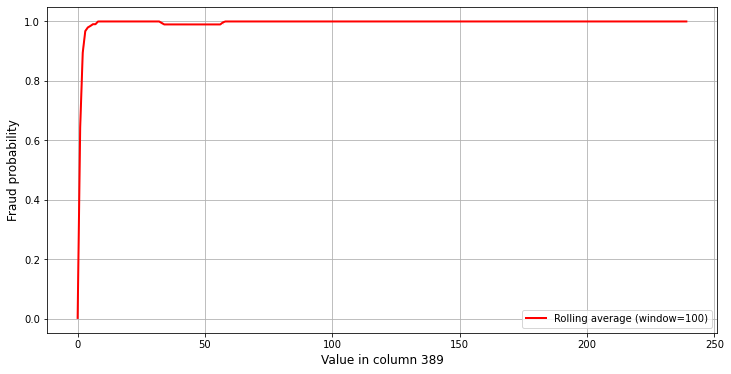

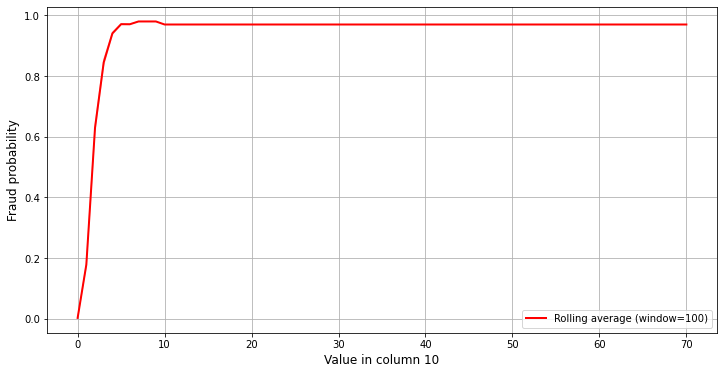

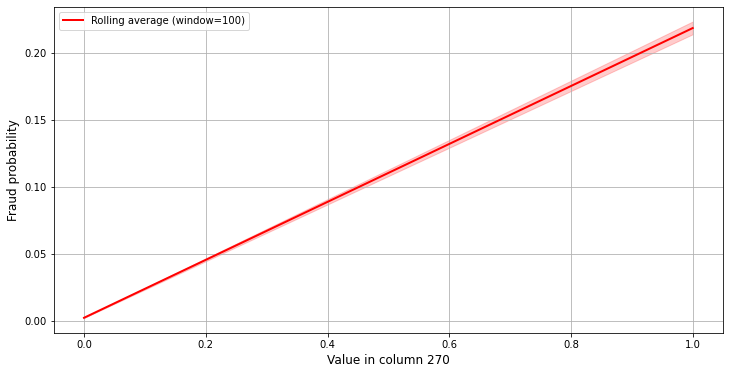

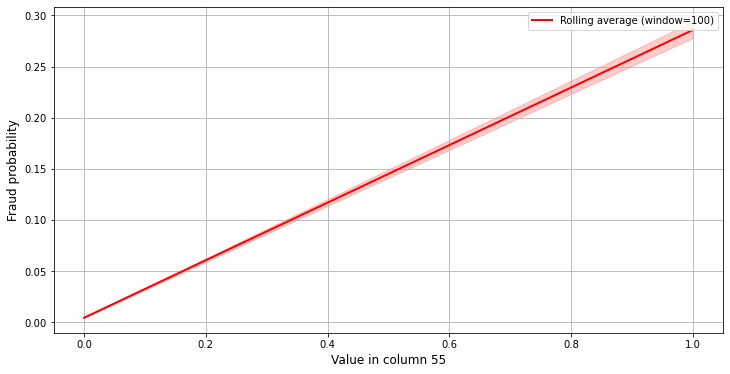

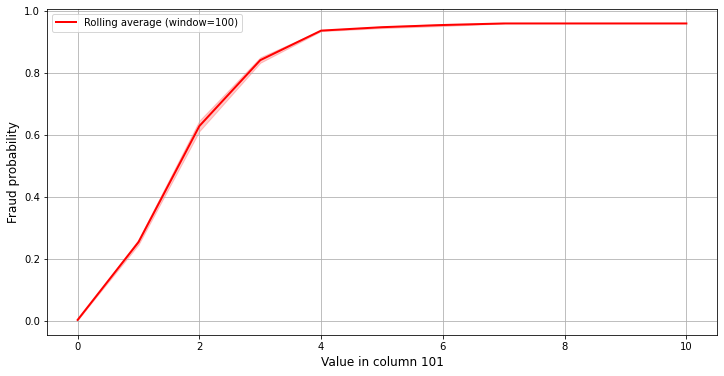

In [22]:
# Revealed 389, 10, 270, 55, 101 columns

for i in ['389', '10', '270', '55', '101']:
    
    df_sorted = df.sort_values(i)

    window_size = 100
    df_sorted[f'rolling_{target_column}'] = df_sorted[target_column].rolling(window=window_size).mean()

    plt.figure(figsize=(12, 6))

    sns.lineplot(x=i, 
                 y='rolling_target', 
                 data=df_sorted, 
                 color='red', linewidth=2, 
                 label=f'Rolling average (window={window_size})')

    plt.xlabel(f'Value in column {i}', fontsize=12)
    plt.ylabel('Fraud probability', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

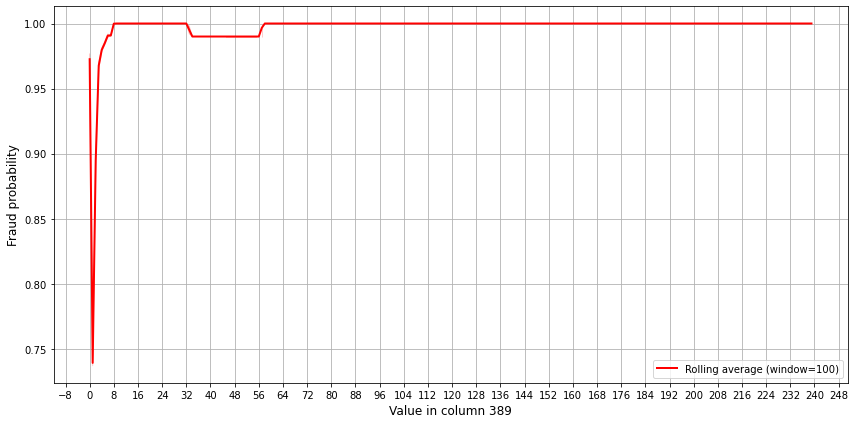

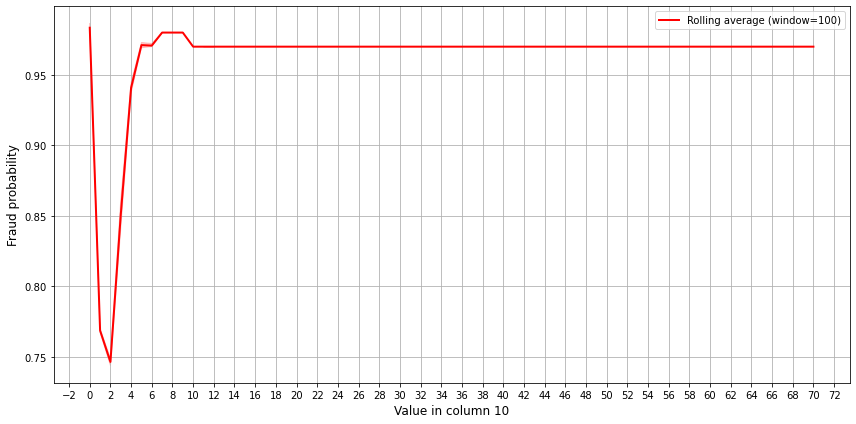

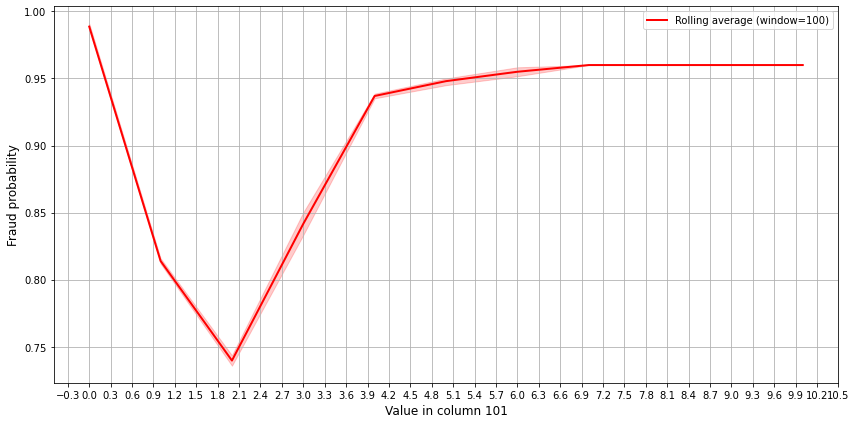

In [23]:
for i in ['389', '10', '101']:
    df_sorted = df.sort_values(i)
    window_size = 100
    df_sorted['rolling_target'] = df_sorted[target_column].rolling(window=window_size).mean()
    
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.lineplot(x=i, 
                 y='rolling_target', 
                 data=df_sorted[df_sorted[f'rolling_{target_column}']>0.7], 
                 color='red', linewidth=2, 
                 label=f'Rolling average (window={window_size})',
                 ax=ax)

    ax.set_xlabel(f'Value in column {i}', fontsize=12)
    ax.set_ylabel('Fraud probability', fontsize=12)
    
    ax.xaxis.set_major_locator(MaxNLocator(nbins=40)) 
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
# Results for feature generation: 
# column 389 rule: (x>=8 and x<=32) or x>=58
# column 10 rule:  >=4
# column 101 rule: >=4

# Feature generation

## Non-zero count

In [25]:
df['non_zero_count'] = (df.iloc[:, 1:-1] != 0).sum(axis=1)

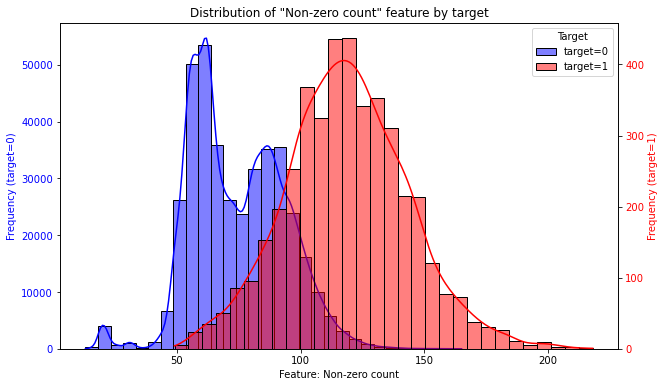

In [26]:
df_0 = df[df[target_column] == 0]
df_1 = df[df[target_column] == 1]

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.histplot(data=df_0, x='non_zero_count', bins=30, kde=True, color='blue', alpha=0.5, ax=ax1, label='target=0')
ax1.set_xlabel('Feature: Non-zero count')
ax1.set_ylabel('Frequency (target=0)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

sns.histplot(data=df_1, x='non_zero_count', bins=30, kde=True, color='red', alpha=0.5, ax=ax2, label='target=1')
ax2.set_ylabel('Frequency (target=1)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, title='Target')

plt.title('Distribution of "Non-zero count" feature by target')
plt.show()

## Numeric threshold 

In [27]:
# column 389 rule: (x>=8 and x<=32) or x>=58
# column 10 rule:  >=4
# column 101 rule: >=4

df['389_more_than_8'] = df['389']>=8
df['389_more_than_58'] = df['389']>=58
df['389_complex'] = ((df['389']>=8) & (df['389']<=32) | (df['389']>=58))
df['10_more_than_4'] = df['10']>=4
df['101_more_than_4'] = df['101']>=4

for i in ['389_more_than_8', '389_more_than_58','389_complex','10_more_than_4','101_more_than_4']:
    print(f'\n-------------\n{i}\n{df[df[i]==True][target_column].value_counts()}')


-------------
389_more_than_8
1.0    1429
0.0       1
Name: target, dtype: int64

-------------
389_more_than_58
1.0    19
Name: target, dtype: int64

-------------
389_complex
1.0    1323
Name: target, dtype: int64

-------------
10_more_than_4
1.0    124
0.0      4
Name: target, dtype: int64

-------------
101_more_than_4
1.0    43
0.0     2
Name: target, dtype: int64


# Conclusion (download)

In [28]:
df.to_parquet('data/dataset_after_eda.parquet')